<a href="https://colab.research.google.com/github/malikpresley/E-commerce/blob/main/Ecommerce_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3

# Connect to the database file to inspect its structure
db_path = '/content/mis380.db'
connection = sqlite3.connect(db_path)

# Query to get all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = connection.execute(tables_query).fetchall()

# Fetch all table names
table_names = [table[0] for table in tables]
table_names


['Customers',
 'Employees',
 'Managers',
 'Order Clerk',
 'OrderDetails',
 'Orders',
 "Product's Cart",
 "Product's Feature",
 'Products',
 'Suppliers',
 'ShippingProviders',
 'ShoppingCart',
 'Categories']

In [ ]:
# Function to fetch and display table schema
def get_table_schema(connection, table_name):
    schema_query = f"PRAGMA table_info('{table_name}');"
    schema = connection.execute(schema_query).fetchall()
    return schema

# Inspecting schema of some key tables
schemas = {table: get_table_schema(connection, table) for table in ['Orders', 'Customers', 'Products', 'OrderDetails']}
schemas

{'Orders': [(0, 'OrderID', 'INTEGER', 1, None, 1),
  (1, 'OrderDate', 'NUMERIC', 0, None, 0),
  (2, 'OrderStatus', 'TEXT', 0, None, 0),
  (3, 'CustomerID', 'INTEGER', 1, None, 0),
  (4, 'EmployeeID', 'INTEGER', 1, None, 0),
  (5, 'ShippingID', 'INTEGER', 0, None, 0),
  (6, 'TotalAmount', 'NUMERIC', 0, None, 0),
  (7, 'Discount', 'INTEGER', 0, None, 0)],
 'Customers': [(0, 'CustomerID', 'INTEGER', 1, None, 1),
  (1, 'FirstName', 'TEXT', 0, None, 0),
  (2, 'LastName', 'TEXT', 0, None, 0),
  (3, 'Email', 'TEXT', 0, None, 0),
  (4, 'PhoneNumber', 'TEXT', 0, None, 0),
  (5, 'StreetAddress', 'TEXT', 0, None, 0),
  (6, 'City', 'TEXT', 0, None, 0),
  (7, 'State', 'TEXT', 0, None, 0),
  (8, 'ZipCode', 'TEXT', 0, None, 0),
  (9, 'Country', 'TEXT', 0, None, 0)],
 'Products': [(0, 'ProductID', 'INTEGER', 1, None, 1),
  (1, 'SupplierID', 'INTEGER', 1, None, 0),
  (2, 'CategoryID', 'INTEGER', 1, None, 0),
  (3, 'Quantity', 'INTEGER', 0, None, 0),
  (4, 'ProductFeatures', 'TEXT', 0, None, 0),
  (5, '

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extracting data from key tables
orders_df = pd.read_sql_query("SELECT * FROM Orders", connection)
customers_df = pd.read_sql_query("SELECT * FROM Customers", connection)
products_df = pd.read_sql_query("SELECT * FROM Products", connection)
order_details_df = pd.read_sql_query("SELECT * FROM OrderDetails", connection)

# Closing the connection as we now have the data in DataFrames
connection.close()

# Displaying first few rows of each DataFrame to understand the data
orders_df.head(), customers_df.head(), products_df.head(), order_details_df.head()

(   OrderID   OrderDate OrderStatus  CustomerID  EmployeeID  ShippingID  \
 0        1  2024-10-15     Shipped        3001         501        9012   
 1        2  2024-09-07  In-transit        3002         502        9013   
 2        3  2024-11-01   Delivered        3003         503        9014   
 3        4  2024-10-20     Shipped        3004         504        9015   
 4        5  2024-11-03     Pending        3005         505        9016   
 
    TotalAmount  Discount  
 0        10.99      0.03  
 1        20.99      0.05  
 2        25.99      0.10  
 3         5.99      0.05  
 4        10.99      0.03  ,
    CustomerID FirstName  LastName                        Email   PhoneNumber  \
 0           1     James    Carter            jcarter@gmail.com  888-999-1111   
 1           2    collin    Carter            jcarter@gmail.com  888-999-1111   
 2        3001   Michael       Mag       MichaelDMaag@rhyta.com  603-530-5296   
 3        3002   William     Davis     WilliamDDavis@da

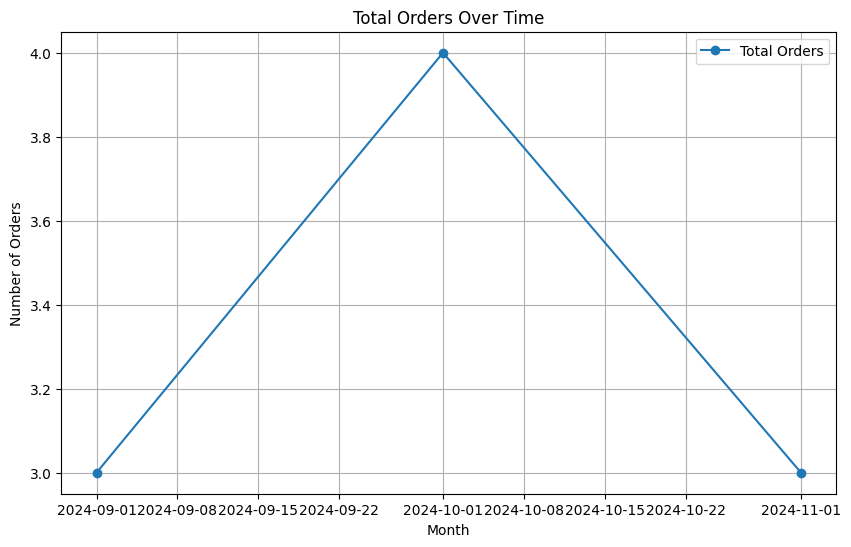

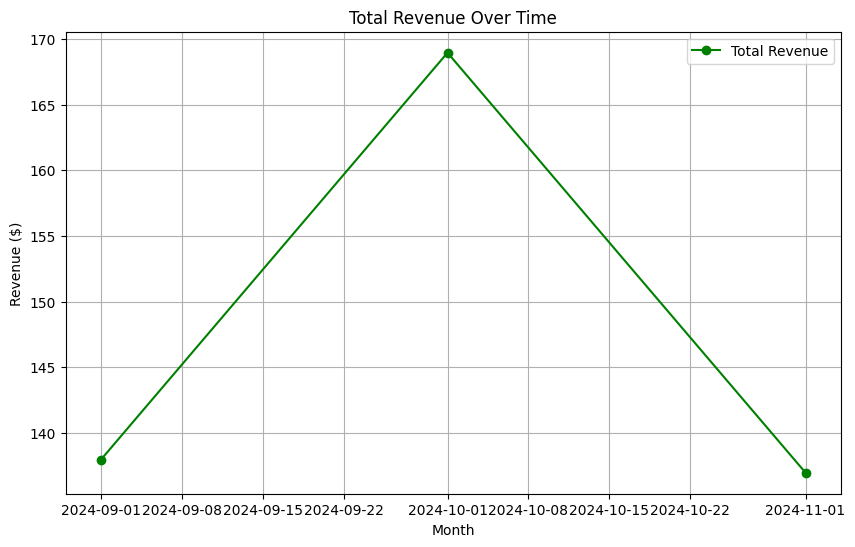

In [ ]:
# Convert OrderDate to datetime for temporal analysis
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'])

# Aggregate total orders and revenue by month
order_metrics = orders_df.groupby(orders_df['OrderDate'].dt.to_period('M')).agg(
    TotalOrders=('OrderID', 'count'),
    TotalRevenue=('TotalAmount', 'sum')
).reset_index()

# Convert period back to datetime for plotting
order_metrics['OrderDate'] = order_metrics['OrderDate'].dt.to_timestamp()

# Plot total orders over time
plt.figure(figsize=(10, 6))
plt.plot(order_metrics['OrderDate'], order_metrics['TotalOrders'], marker='o', label='Total Orders')
plt.title('Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend()
plt.show()

# Plot total revenue over time
plt.figure(figsize=(10, 6))
plt.plot(order_metrics['OrderDate'], order_metrics['TotalRevenue'], marker='o', label='Total Revenue', color='green')
plt.title('Total Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.legend()
plt.show()


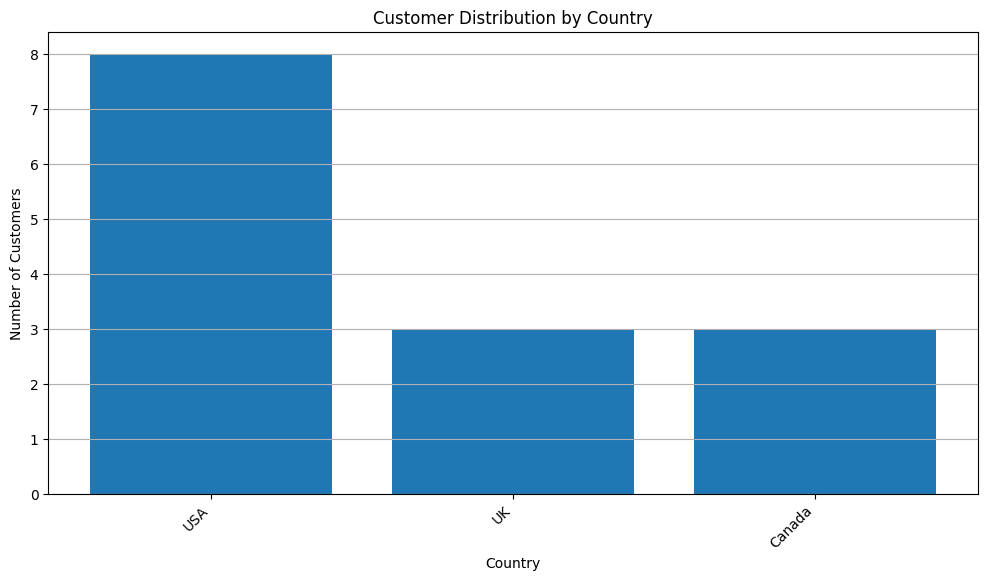

In [ ]:
# Customer distribution by country
customer_distribution = customers_df['Country'].value_counts().reset_index()
customer_distribution.columns = ['Country', 'CustomerCount']

# Plot customer distribution by country
plt.figure(figsize=(12, 6))
plt.bar(customer_distribution['Country'], customer_distribution['CustomerCount'])
plt.title('Customer Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [ ]:
# Rename conflicting columns in the Products DataFrame before merging
products_df_renamed = products_df.rename(columns={'Quantity': 'StockQuantity'})

# Merge the updated Products table with OrderDetails
product_sales_fixed = order_details_df.merge(products_df_renamed, on='ProductID')

# Display the corrected columns of the merged DataFrame
product_sales_fixed.columns


Index(['OrderDetailID', 'OrderID', 'ProductID', 'Quantity', 'UnitPrice',
       'TotalPrice', 'SupplierID', 'CategoryID', 'StockQuantity',
       'ProductFeatures', 'UnitsInStock', 'UnitsOnOrder', 'Discontinued',
       'ProductName', 'CartID'],
      dtype='object')

In [ ]:
# Redefine the merge operation to correctly create product_sales
product_sales_fixed = order_details_df.merge(products_df_renamed, on='ProductID', how='inner')

# Check the columns of the merged DataFrame
product_sales_fixed.columns

Index(['OrderDetailID', 'OrderID', 'ProductID', 'Quantity', 'UnitPrice',
       'TotalPrice', 'SupplierID', 'CategoryID', 'StockQuantity',
       'ProductFeatures', 'UnitsInStock', 'UnitsOnOrder', 'Discontinued',
       'ProductName', 'CartID'],
      dtype='object')

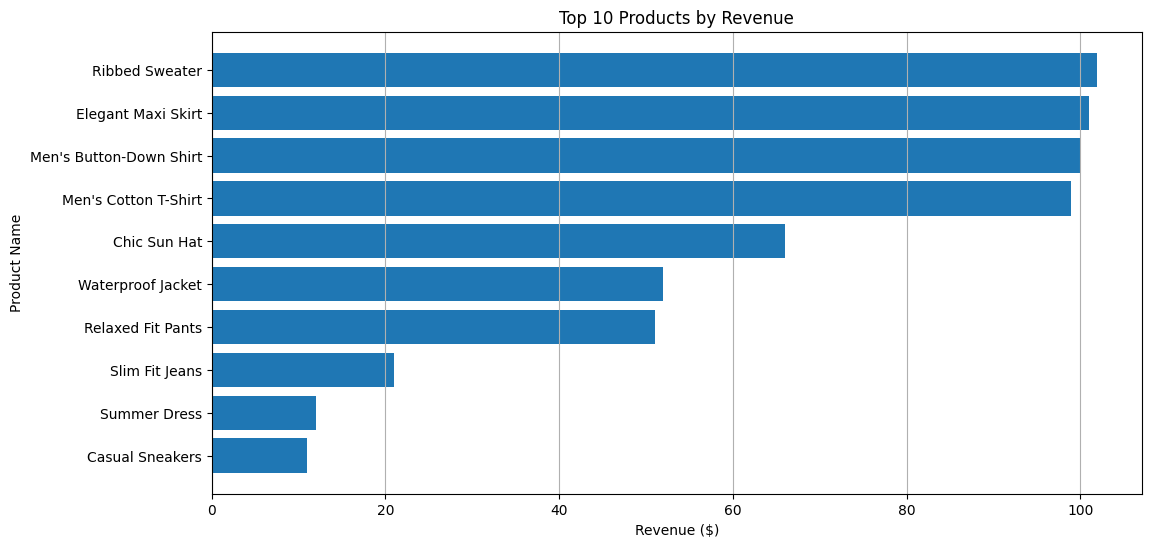

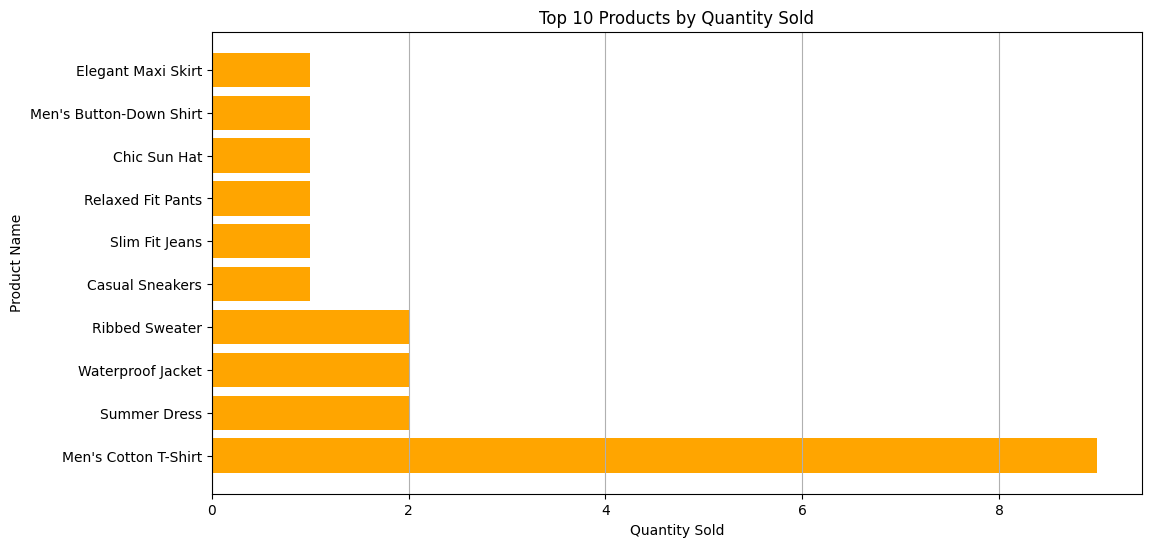

In [ ]:
# Merge OrderDetails with the renamed Products table to create product_sales
product_sales = order_details_df.merge(products_df_renamed, on='ProductID', how='inner')

# Perform aggregation: total quantity sold and revenue by product
top_products_corrected = product_sales.groupby('ProductName').agg(
    TotalQuantity=('Quantity', 'sum'),  # Correct column from OrderDetails
    TotalRevenue=('TotalPrice', 'sum')  # Revenue is correctly sourced
).reset_index()

# Sort by total revenue to identify top products
top_products_corrected = top_products_corrected.sort_values(by='TotalRevenue', ascending=False).head(10)

# Plot top products by revenue
plt.figure(figsize=(12, 6))
plt.barh(top_products_corrected['ProductName'], top_products_corrected['TotalRevenue'])
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Product Name')
plt.gca().invert_yaxis()  # Invert y-axis to show highest at the top
plt.grid(axis='x')
plt.show()

# Sort by total quantity for the second visualization
top_quantity_corrected = top_products_corrected.sort_values(by='TotalQuantity', ascending=True)  # Sort for horizontal bar chart

# Plot top products by quantity sold
plt.figure(figsize=(12, 6))
plt.barh(top_quantity_corrected['ProductName'], top_quantity_corrected['TotalQuantity'], color='orange')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Name')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()
